<a href="https://colab.research.google.com/github/marcio-lfo/devai/blob/main/Arvore_Decisao_Heuristica_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from sklearn.datasets import load_wine
import pandas as pd

wine = load_wine()
X, y = wine.data, wine.target

In [76]:
descricao = wine['DESCR']
print(descricao)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

In [77]:
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [79]:
wine.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [78]:
# Verificando o tamando do dataset e quantidade de amostras

set(y), len(y)

({0, 1, 2}, 178)

# Observação:

. O dataset possui 178 amostras de vinhos divididas em 3 classes. Cada amostra possui 13 atributos.

. Cada classe possui 59, 71 e 48 amostras cada.

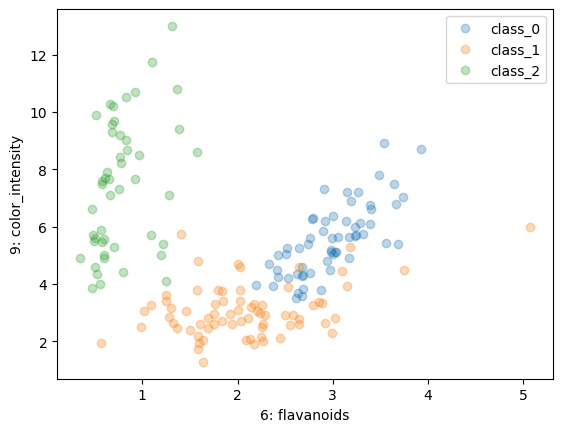

In [80]:
# Plotando o gráfico das características Color_Intensity (9) e Flavanoids (6)

import matplotlib.pyplot as plt

i, j = 6, 9
plt.xlabel(f"{i}: {wine.feature_names[i]}")
plt.ylabel(f"{j}: {wine.feature_names[j]}")

for k in set(y):
      plt.plot(X[:,i][y==k],X[:,j][y==k], 'o', alpha=0.3,
               label=f"{wine.target_names[k]}")
plt.legend()
plt.show()

In [81]:
# Trabalhando com o modelo ZeroR

from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_validate

# Criando a função maisFrequente retornando o 1º elemento mais comum, qual é o elemento e a quantidade
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.resposta = maisFrequente(y)
        return self
    def predict(self, X, y=None):
        y = np.empty((X.shape[0]))
        y[:] = self.resposta
        return y

scores = cross_validate(ZeroR(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.38888889, 0.38888889, 0.38888889, 0.4       , 0.42857143]),
 0.3990476190476191)

# Observação:

. O resultado **0.39** indica que para o conjunto de dados a estratégia de prever sempre a classe mais frequente não é muito eficaz em termos de precisão.

In [82]:
modelo = ZeroR()
modelo.fit(X, y)
modelo.resposta

1

# Observação:

. A classe **1**, segundo o modelo ZeroR, é a mais frequente.



In [83]:
modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.398876404494382

# Observação:

. O resultado acima obtido ao calcular a taxa de acerto no conjunto de dados de treinamento indica que aproximadamente 39,89% das previsões foram corretas no conjunto de dados de treinamento, consistente com a análise que mostrou uma média de teste em torno de 40% durante a validação cruzada. Ambos resultados sugerem que o modelo que prevê a classe mais frequente tem um desempenho limitado neste conjunto de dados específico.



In [84]:
def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i, valor])
            impurezaValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezaValorCaracteristica)
    impurezas = np.array(impurezas)
    menorImpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorImpureza]
    return impurezas[menorImpureza], caracteristica, valor

impurezaMinima(X, y)

(array([0.65213228, 0.        , 0.65954287]), 0, 11.41)

In [85]:
# Modelo utilizando a impureza mínima

class Arvore_A(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.impureza, self.caracteristica, self.valor = impurezaMinima(X, y)
        maiores = X[:, self.caracteristica] > self.valor
        #print(self.impureza, self.caracteristica, self.valor, sum(iguais), sum(~iguais))
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_A()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore_A()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
        return self

    # Se esse nó tiver o atributo resposta quer dizer que é um nó folha
    # caso contrário a resposta está em algum subnível
    def predict(self, X, y=None):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore_A()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.7303370786516854

In [86]:
# Utilizando a métrica Gini para calcular a impureza

def impureza(y):
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels,)))
    for i, k in enumerate(labels):
      probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades ** 2)
    return result

impureza(y[:])

0.6583133442747129

# Observação:

. A métrica de Gini é uma medida que avalia quão impuro é um conjunto de dados em termos de distribuição de classes. Ela varia de 0 a 1, onde:

*   0 indica pureza máxima, ou seja, todas as amostras pertencem à mesma classe.
*   1 indica impureza máxima, ou seja, as amostras estão distribuídas uniformemente entre as classes.


. O resultado de **0,658** indica que o conjunto de rótulos y tem impureza relativamente alta, há uma mistura de diferentes classes no conjunto de dados.

In [87]:
# Calulando a impureza de uma característica específica

def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezamaiores = impureza(y[maiores])
  proporcaomaiores = sum(maiores)/len(y)
  impurezamenores = impureza(y[~maiores])
  proporcaomenores = sum(~maiores)/len(y)
  # Média ponderada
  impurezaTotal = proporcaomaiores*impurezamaiores + proporcaomenores*impurezamenores
  return impurezaTotal, impurezamenores, impurezamaiores

# Calculando o valor da impureza para a caracterítica 2, do nosso X, com o valor 2
impurezaValor(X[:,2], y, 2)

(0.593314960073493, 0.0, 0.6642142320319608)

In [132]:
# Criando a função para encontrar o melhor valor

def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

In [133]:
# Criando a função para obter a melhor característica

def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    # print(impurezas)
    # print(valores)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return impurezas[caracteristica], caracteristica, valores[caracteristica]

melhorCaracteristica(X, y)

(0.43761750381193476, 12, 979.0)

# Observação:


. Ao utilizar a função **melhorCaracterisitca** destaca-se a característica **12** com impureza de **0.437**, no valor de **979.0**.


In [96]:
# Utilizando o modelo usando a melhor característica

class Arvore_B(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
        maiores = X[:, self.caracteristica] > self.valor
        #print(self.impureza, self.caracteristica, self.valor, sum(iguais), sum(~iguais))
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore_B()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore_B()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
        return self

    # Se esse nó tiver o atributo resposta quer dizer que é um nó folha
    # caso contrário a resposta está em algum subnível
    def predict(self, X, y=None):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore_B()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

1.0

In [91]:
# Validação cruzada

scores = cross_validate(Arvore_B(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.77777778, 0.88888889, 0.83333333, 1.        , 0.97142857]),
 0.8942857142857144)

# Observação:

. Os scores variam de **0.777** a **1**.

. O modelo classificou corretamente cerca de **89,42%** das amostras nos conjuntos de teste.

In [137]:
# Criando a função para plotar o gráfico que permita plotar contornos

import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0]-0.2), np.max(X[:,0])+0.2,100)
    x1s = np.linspace(np.min(X[:,1]-0.2), np.max(X[:,1])+0.2,100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o')
    plt.show()


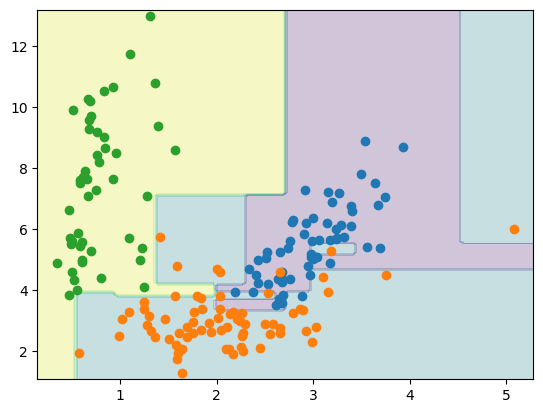

In [135]:
# Plotando as características 6 e 9
plotDecisao(Arvore_B(), X[:,[6,9]], y)

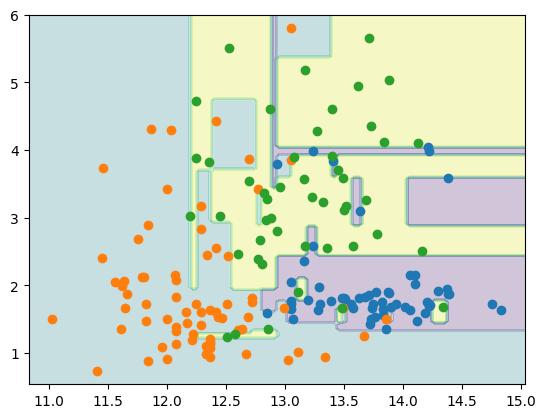

In [136]:
# Plotando as características 0 e 1
plotDecisao(Arvore_B(), X[:,[0,1]], y)

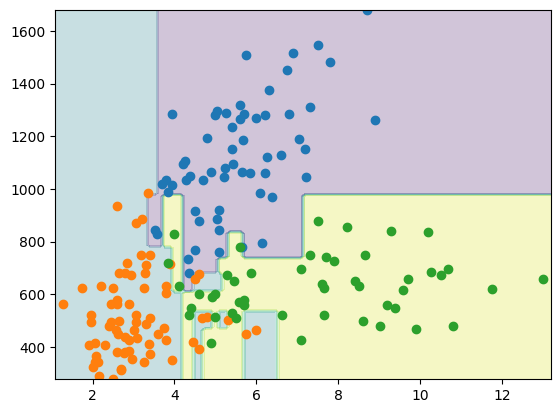

In [93]:
# Plotando as características 9 e 12
plotDecisao(Arvore_B(), X[:,[9,12]], y)

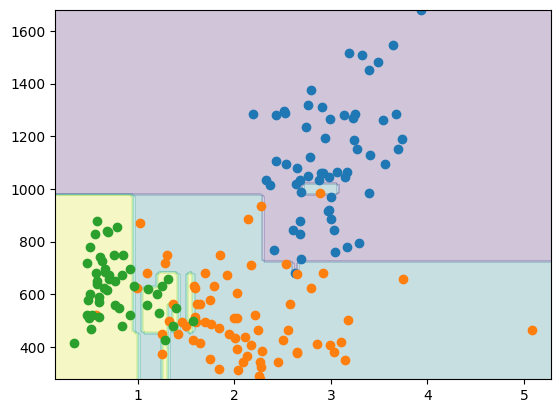

In [100]:
# Plotando as características 6 e 12
plotDecisao(Arvore_B(), X[:,[6,12]], y)

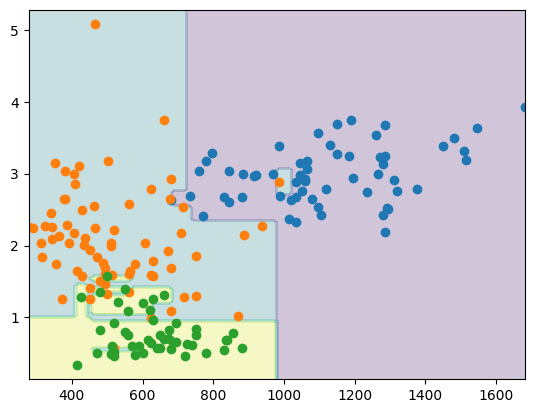

In [127]:
# Plotando as características 12 e 6
plotDecisao(Arvore_B(), X[:,[12,6]], y)

In [138]:
# Medição do tempo de treinamento utilizando a miníma impureza
modelo = Arvore_A()
print(f"Tempo total do modelo Arvore_A (mínima impureza): ")
%timeit modelo.fit(X, y)

# Medição do tempo de treinamento utilizando a melhor característica
modelo = Arvore_B()
print(f"\nTempo total do modelo Arvore_B (melhor característica): ")
%timeit modelo.fit(X, y)


Tempo total do modelo Arvore_A (mínima impureza): 
4.12 s ± 838 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Tempo total do modelo Arvore_B (melhor característica): 
233 ms ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Conclusão:

. Com relação ao desempenho, o modelo **Arvore_B** que utilizou a função **melhorCaracteristica** apresentou um retorno melhor, sendo mais rápido.

. Ao escolher a característica **12** e usar o valor **979.0**, obtemos a menor impureza entre todas as características, indicando ser os valores mais adequados para separar as classes no conjunto de dados.